<h2><strong>Ship Satellite Image Classification Using VGG16 Transfer Learning Algorithm</strong></h2>

<strong>Trainee:</strong> Mesuga, Reymond R.


##<h3><strong>Mounting the Google Drive<strong></h3>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install split-folders

##<h3><strong>Importing Necessary Packages<strong></h3>

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
import cv2
import imutils as imutils
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning
from tqdm import tqdm # make your loops show a smart progress meter 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import splitfolders

from tensorflow.keras.applications import vgg16

from tensorflow.keras.applications.vgg16 import VGG16


RANDOM_SEED = 42 # To make the outputs reproducible
IMG_SIZE = (80,80) # Given size of the images

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)

##<h3><strong>About the Dataset</strong></h3><br>
The dataset that will be used in this exercise is from a Kaggle repository named <a href="https://www.kaggle.com/rhammell/ships-in-satellite-imagery">Ships in Satellite Imagery</a>. This dataset contains image chips extracted from <a href="https://www.planet.com/">Planet Satellite Imagery</a> collected over the San Francisco Bay and San Pedro Bay areas of California. The total number of images in the dataset is 6400 with the size of 80x80 pixels which can be classified as ship or no-ship.

##<h3><strong>Splitting the Dataset</strong></h3><br>
The dataset will be splitted into three folders namely train, val, and test folder. The `train` folder contains the 80% of the images which will be used to train the algorithm. The `val` folder contains the images that will be used for hyperparameter tuning. While `test` folder contains the images that will be used to compute the final accuracy of the model.

<table>
  <tr>
  <th></th>
  <th>Training Set</th>
  <th>Validation Set</th>
  <th>Test Set</th>
  </tr>
  <tr>
  <td>ship</td>
  <td>800</td>
  <td>100</td>
  <td>100</td>
  </tr>
  <tr>
  <td>no-ship</td>
  <td>2400</td>
  <td>300</td>
  <td>300</td>
  </tr>
</table>

In [ ]:
%%time
!mkdir Splitted_Dataset
input_folder_path = "/content/drive/MyDrive/Personal-Project-Datasets/shipsnet"
output_folder_path = "Splitted_Dataset"
splitfolders.ratio(input_folder_path, output=output_folder_path, seed=42, ratio=(.8, .1, .1), group_prefix=None) # default values

Copying files: 4000 files [14:36,  4.56 files/s]

CPU times: user 15.2 s, sys: 6.43 s, total: 21.6 s
Wall time: 14min 36s


In [ ]:
Training_Path = "/content/Splitted_Dataset/train/"
Validation_Path = "/content/Splitted_Dataset/val/"
Test_Path = "/content/Splitted_Dataset/test/"
os.listdir(Training_Path)

['ship', 'no-ship']

In [ ]:
def number_of_imgs(path):
  print(path)
  for value in os.listdir(path):
    print(value, "has", len(os.listdir(path + value)), "img", "\n")
number_of_imgs(Test_Path)
number_of_imgs(Training_Path)
number_of_imgs(Validation_Path)

/content/Splitted_Dataset/test/
ship has 100 img 

no-ship has 300 img 

/content/Splitted_Dataset/train/
ship has 800 img 

no-ship has 2400 img 

/content/Splitted_Dataset/val/
ship has 100 img 

no-ship has 300 img 



##<h3><strong>Data Visualization</strong></h3>

The codes below can randomly generate images from the folder of Training Set, Validation Set and Test Set.

In [ ]:
def create_dataframe(path):
    data = []
    for value in os.listdir(path):
        for image in os.listdir(path + value + "/"):
            file_path = path + value + "/" + image
            # if ship then set it to 1 else 0
            ship = 1 if value == "ship" else 0
            data.append({"path": file_path, 'ship': ship})
            
    df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

    return df

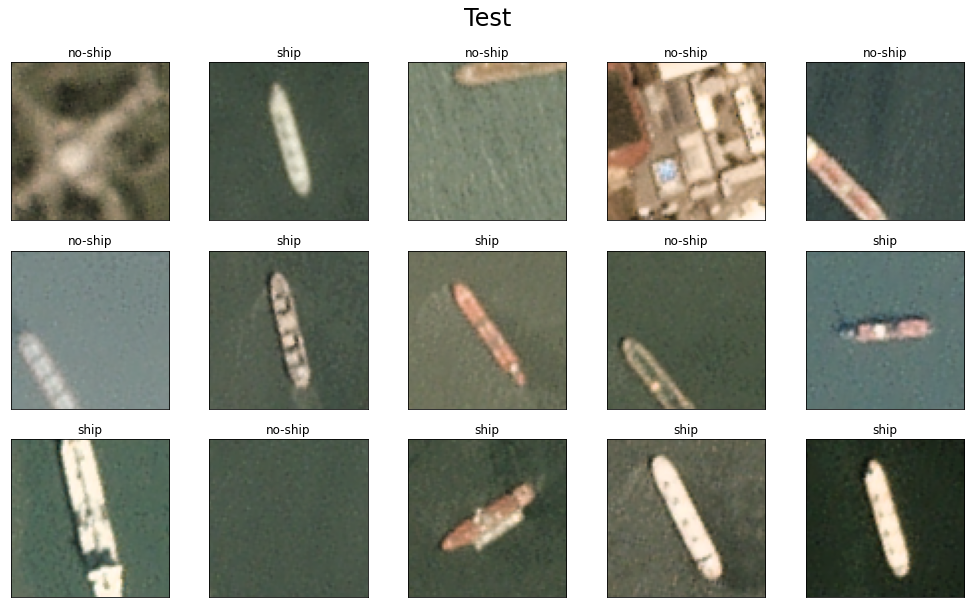

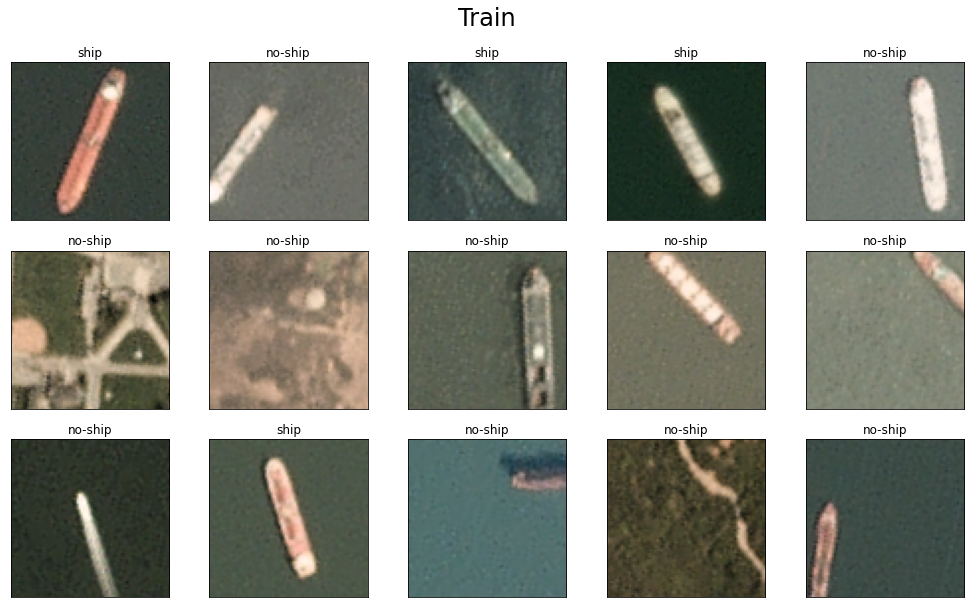

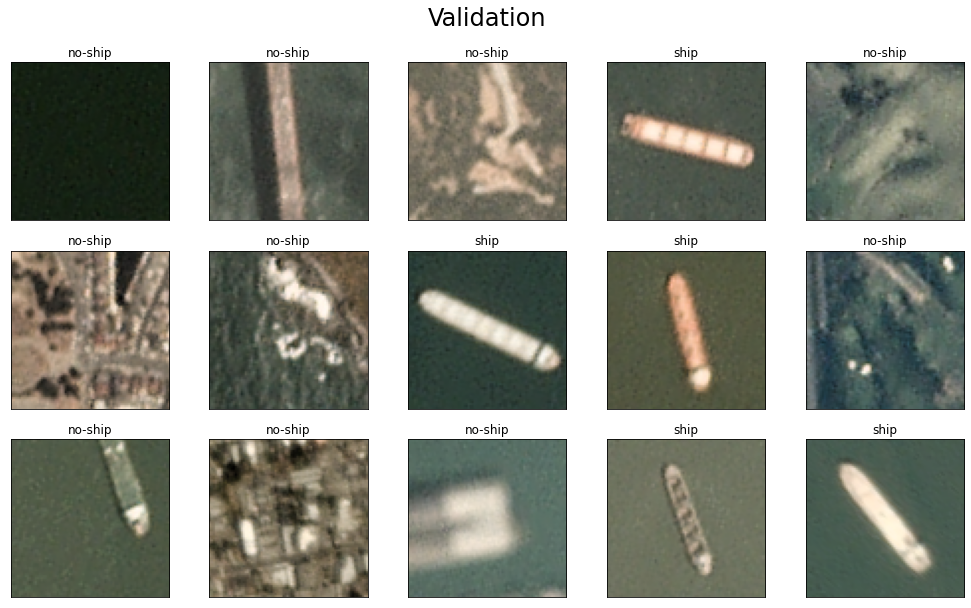

CPU times: user 3.56 s, sys: 326 ms, total: 3.88 s
Wall time: 3.62 s


In [ ]:
%%time
% matplotlib inline
def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'ship' if row['ship'] == 1 else 'no-ship'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()
    
    
plot_imgs("Test", create_dataframe(Test_Path).sample(15).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_Path).sample(15).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_Path).sample(15).reset_index(drop=True))

##<h3><strong>Creating Data Generators</strong></h3><br>
Data generators or `datagens` enables us to feed the data into the model in batches and let the model study or classify the data in batches. This practice is very helpful to save a lot of memory during training.

In [ ]:
%%time
reset_random_seeds()
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    Training_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=14,
    class_mode='binary',
    seed=RANDOM_SEED
)
validation_generator = val_datagen.flow_from_directory(
    Validation_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=7,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 329 ms


##<h3><strong>Model Building, Training and Evaluation</strong></h3>

###<h3><strong>Creating Helper Functions</strong></h3>
Helper functions are useful to avoid unnecessary repetitions of the code and make the source code more modular.

####<h5><strong>Helper Function for Building the Model</strong></h5>

In [ ]:
%%time
def model_builder(keras_model, droupout_rate, dense_node, activation_type, learning_rate):
  """
  keras_model = any model that can be imported from Keras applications.
  droupout_rate = Float between 0 and 1. Fraction of the input units to drop.
  dense_node = represents the number of units (neurons)
  activation_type = represent activation to be used
  learning_rate = A Tensor, floating point value. Defaults to 0.001.
  """
  reset_random_seeds()
  
  base_model = keras_model(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
  )

  model = tf.keras.models.Sequential()
  model.add(base_model)
  model.add(tf.keras.layers.Dropout(droupout_rate))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(dense_node,activation=activation_type))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.layers[0].trainable = False

  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      metrics=['accuracy']
  )

  model.summary()
  return model

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


####<h5><strong>Helper Function for Training the Model</strong></h5>

In [ ]:
%%time
def model_trainer(model, epochs):
  """
  model = represents the model built using the function `model_builder`.
  epochs = defines the number times that the learning algorithm will work through the entire training dataset
  """
  reset_random_seeds()
  
  EPOCHS = epochs
  
  history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=25,
  )
  print("Training Done")
  model_training_history = {"history": history,
                   "model": model
                   }
  return model_training_history

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


####<h5><strong>Helper Function for Visualization of the Training Results</strong></h5>

In [ ]:
def training_result_visualizer(Training_History):
  """
  Training_History = e.g., Training_History_VGG16["history"]
  """
  reset_random_seeds()
  
  %matplotlib inline
  acc = Training_History.history["accuracy"]
  val_acc = Training_History.history["val_accuracy"]
  loss = Training_History.history["loss"]
  val_loss = Training_History.history["val_loss"]

  epochs_range = range(1, len(Training_History.epoch)+1)

  plt.figure(figsize=(10,5))

  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc="best")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  

  plt.figure(figsize=(10,5))

  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc="best")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Model Loss')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

####<h5><strong>Helper Function for Validation and Test Accuracy</strong></h5>

In [ ]:
%%time
def Accuracy_Score(Path, model):
  reset_random_seeds()
  def preprocess_imgs(path, img_size):
    reset_random_seeds()
    set_new = []
    for value in os.listdir(path):
      for img in os.listdir(path + value):
        img = cv2.imread(path + value + "/" + img)
        set_new.append(tf.keras.applications.vgg16.preprocess_input(img))
    return np.array(set_new)

  test_data = preprocess_imgs(Path, img_size=IMG_SIZE)

  reality = []
  for value in os.listdir(Path):
    for img in os.listdir(Path + value):
      reality.append(1) if value == "no-ship" else reality.append(0)
  
  predictions = model.predict(test_data)
  predictions = [0 if x > 0.5 else 1 for x in predictions]

  accuracy = accuracy_score(reality, predictions)
  print("Accuracy:", accuracy)

  # Confusion Matrix
  confusion_mtx = confusion_matrix(reality, predictions)
  
  ax = plt.axes()
  sn.heatmap(confusion_mtx, annot=True, annot_kws={"size": 25}, cmap="Blues", ax=ax)
  ax.set_title('Confusion Matrix', size=14)
  plt.show() 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


###<h5><strong>VGG16: Defining the Model</strong></h5>

In [ ]:
%%time
Model_VGG16 = model_builder(VGG16, droupout_rate=0.5, dense_node=512, activation_type="relu", learning_rate=0.001)
Model_VGG16

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-

###<h5><strong>VGG16: Training the Model</strong></h5>

In [ ]:
%%time
Training_History_VGG16 = model_trainer(Model_VGG16, epochs=20)
Training_History_VGG16

Epoch 1/20
50/50 [==============================] - 33s 61ms/step - loss: 0.3167 - accuracy: 0.8843 - val_loss: 0.2390 - val_accuracy: 0.9314
Epoch 2/20
50/50 [==============================] - 2s 45ms/step - loss: 0.1151 - accuracy: 0.9600 - val_loss: 0.0752 - val_accuracy: 0.9771
Epoch 3/20
50/50 [==============================] - 2s 47ms/step - loss: 0.0660 - accuracy: 0.9714 - val_loss: 0.0125 - val_accuracy: 0.9943
Epoch 4/20
50/50 [==============================] - 3s 57ms/step - loss: 0.0580 - accuracy: 0.9798 - val_loss: 0.0324 - val_accuracy: 0.9886
Epoch 5/20
50/50 [==============================] - 2s 45ms/step - loss: 0.0681 - accuracy: 0.9769 - val_loss: 0.0313 - val_accuracy: 0.9943
Epoch 6/20
50/50 [==============================] - 2s 45ms/step - loss: 0.0427 - accuracy: 0.9857 - val_loss: 0.0396 - val_accuracy: 0.9886
Epoch 7/20
50/50 [==============================] - 2s 46ms/step - loss: 0.0444 - accuracy: 0.9856 - val_loss: 0.0327 - val_accuracy: 0.9886
Epoch 8/20
5

###<h5><strong>VGG16: Visualization of the Training Results</strong></h5>

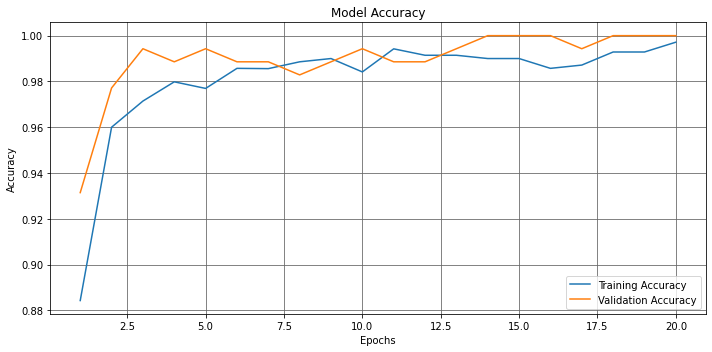

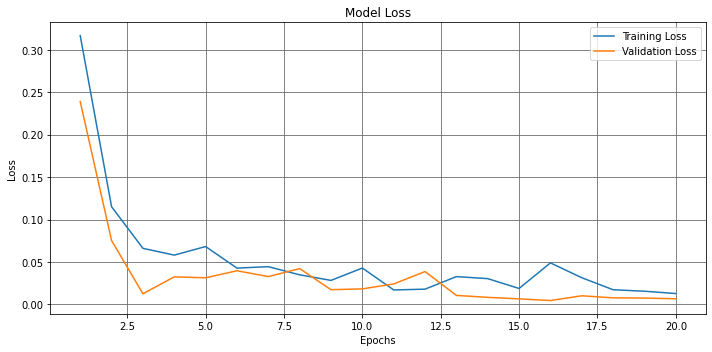

In [ ]:
VGG16_Training_Results = training_result_visualizer(Training_History_VGG16["history"])
VGG16_Training_Results

###<h5><strong>VGG16: Validation Accuracy</strong></h5>


Accuracy: 0.9925


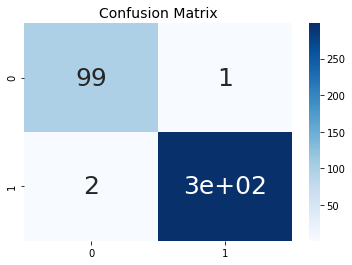

CPU times: user 3.45 s, sys: 152 ms, total: 3.6 s
Wall time: 3.53 s


In [ ]:
%%time
Accuracy_Score(Validation_Path, Training_History_VGG16["model"])

##<h3><strong>Hyperparameter Tuning: Improving the Model</strong></h3>

###<h3><strong>Creating Helper Functions</strong></h3>
The helper functions here in hyperparameter tuning generates the plotted accuracy of different values of hyperparameter. This is to visualize better the performance of different values of hyperparameter and ease decision making.

####<h5><strong>Helper Function for Changing Dropout Rate</strong></h5>

In [ ]:
def Accuracy_Score_for_Tuning(Path, model):
  reset_random_seeds()
  def preprocess_imgs(path, img_size):
    reset_random_seeds()
    set_new = []
    for value in os.listdir(path):
      for img in os.listdir(path + value):
        img = cv2.imread(path + value + "/" + img)
        set_new.append(tf.keras.applications.vgg16.preprocess_input(img))
    return np.array(set_new)

  test_data = preprocess_imgs(Path, img_size=IMG_SIZE)

  reality = []
  for value in os.listdir(Path):
    for img in os.listdir(Path + value):
      reality.append(1) if value == "no-ship" else reality.append(0)
  
  predictions = model.predict(test_data)
  predictions = [0 if x > 0.5 else 1 for x in predictions]

  accuracy = accuracy_score(reality, predictions)
  return accuracy

In [ ]:
%%time
def param_tuning_with_dropout( keras_model, dropout_rates ):
  reset_random_seeds()
  Accuracy = []
  for rate in dropout_rates:
    reset_random_seeds()
    Model = model_builder(keras_model, rate, dense_node=512, activation_type="relu", learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")
    print("Dropout Rate: ", rate)
  
    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)

  print("This is the plot of the recorded Accuracy per Droupout Rate")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Dropout")
  plt.plot(dropout_rates, Accuracy, 'r-o')
  plt.xlabel("Dropout Rate")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()
  

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


####<h5><strong>Helper Function for Changing Activation Type</strong></h5>

In [ ]:
def param_tuning_with_activation( keras_model, activation_types ):
  reset_random_seeds()
  Accuracy = []
  for type in activation_types:
    reset_random_seeds()
    Model = model_builder(keras_model, droupout_rate=0.5, dense_node=512, activation_type=type, learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")

    print("Activation Type: ", type)

    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)
  
  print("This is the plot of the recorded Accuracy per Activation Type")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Activation")
  plt.plot(activation_types, Accuracy, 'r-o')
  plt.xlabel("Activation")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

####<h5><strong>Helper Function for Changing Number of Node</strong></h5>

In [ ]:
%%time
def param_tuning_with_Nodes( keras_model, set_of_nodes ):
  reset_random_seeds()
  Accuracy = []
  for nodes in set_of_nodes:
    reset_random_seeds()
    Model = model_builder(keras_model, droupout_rate=0.5, dense_node=nodes, activation_type="relu", learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")

    print("Number of Nodes: ", nodes)

    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)
  
  print("This is the plot of the recorded Accuracy per Number of Nodes in the head of a Transfer Learning model")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Nodes")
  plt.plot(set_of_nodes, Accuracy, 'r-o')
  plt.xlabel("No. of Node")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.2 µs


###<h3><strong>Changing Dropout Rate</strong></h3>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

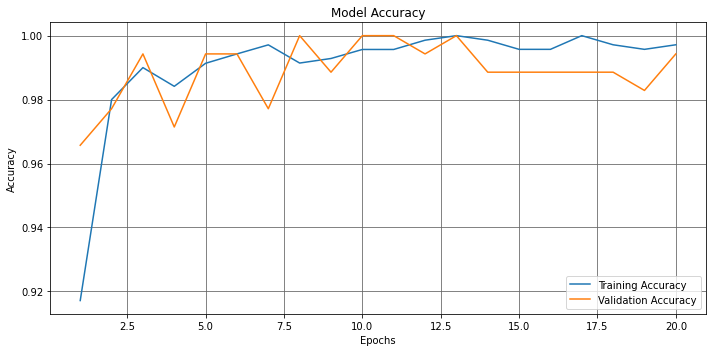

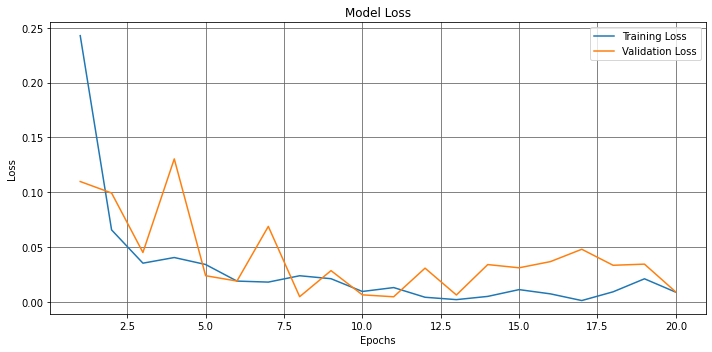

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

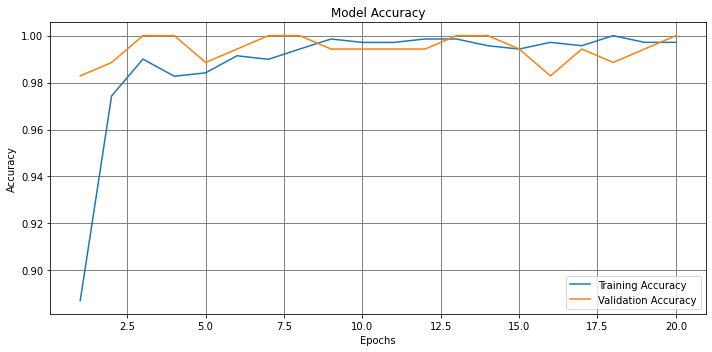

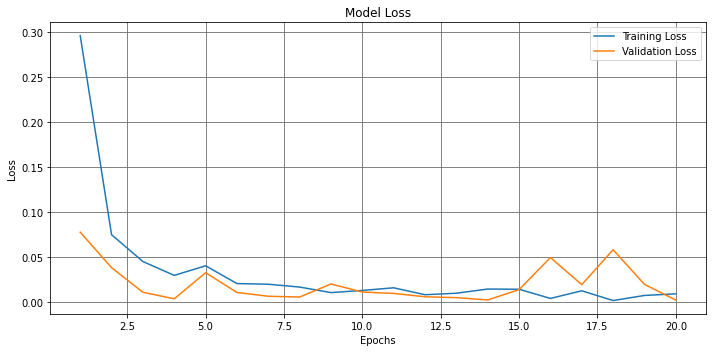

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

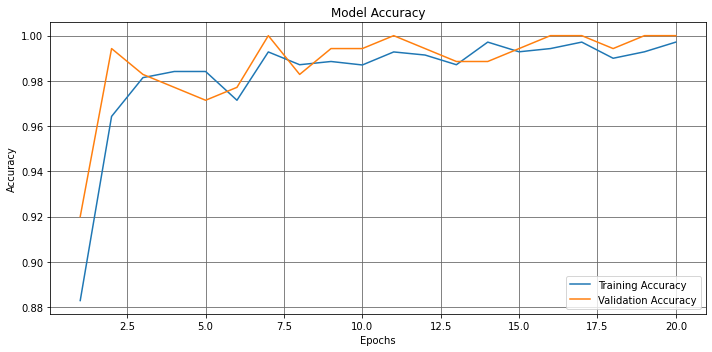

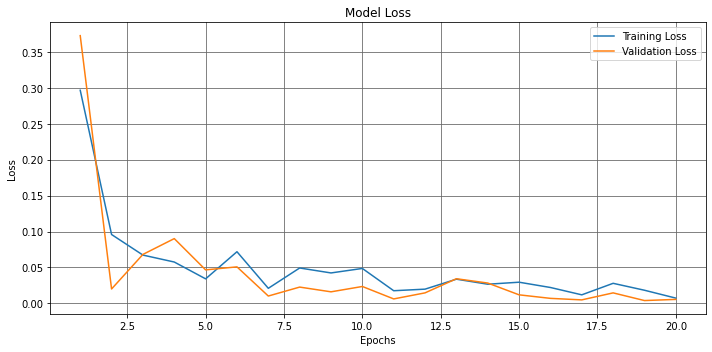

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

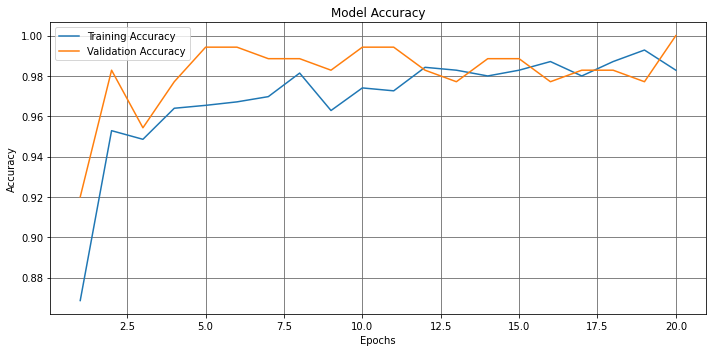

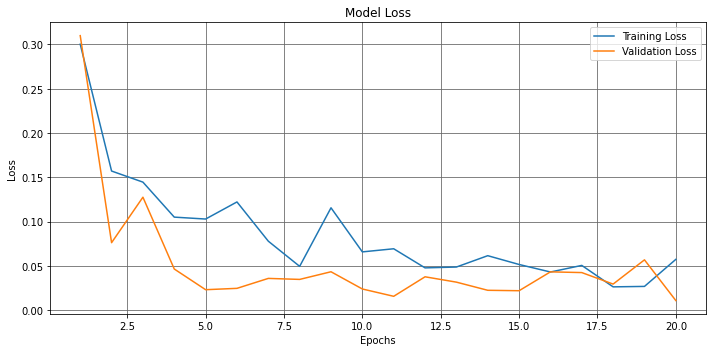

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

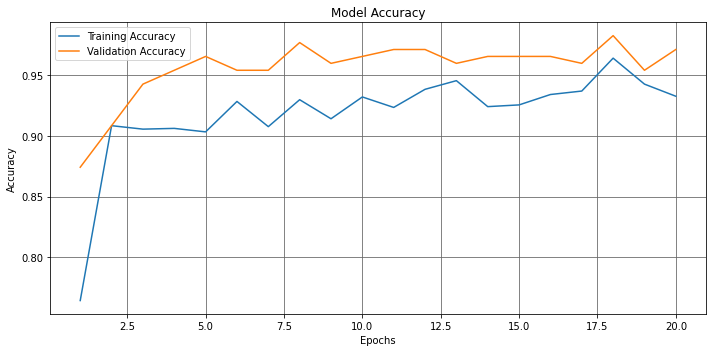

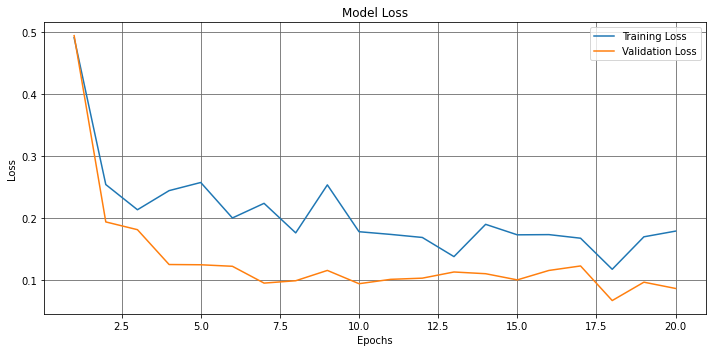

This is the plot of the recorded Accuracy per Droupout Rate
[0.99, 0.995, 0.995, 0.9825, 0.9675]


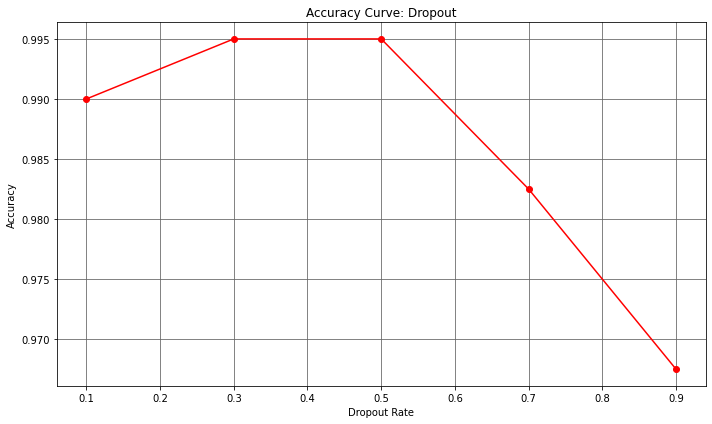

CPU times: user 3min 8s, sys: 17.3 s, total: 3min 26s
Wall time: 4min 34s


In [ ]:
%%time
param_tuning_with_dropout( VGG16, dropout_rates=[0.1, 0.3, 0.5, 0.7, 0.9])

###<h3><strong>Changing Activation Type</strong></h3>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

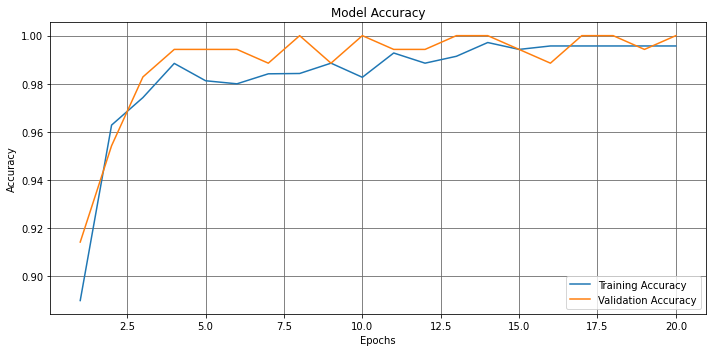

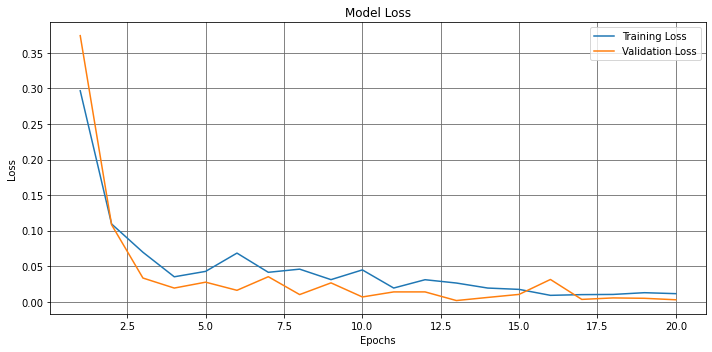

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

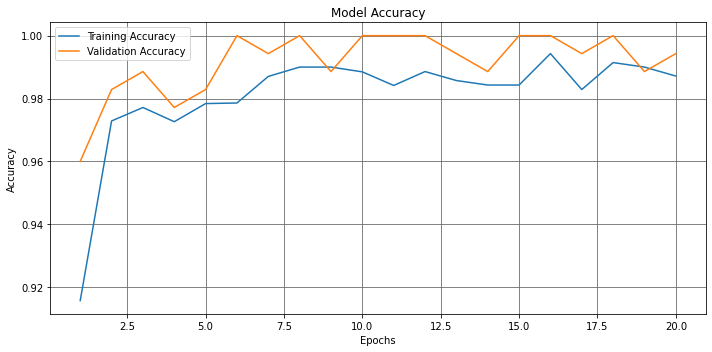

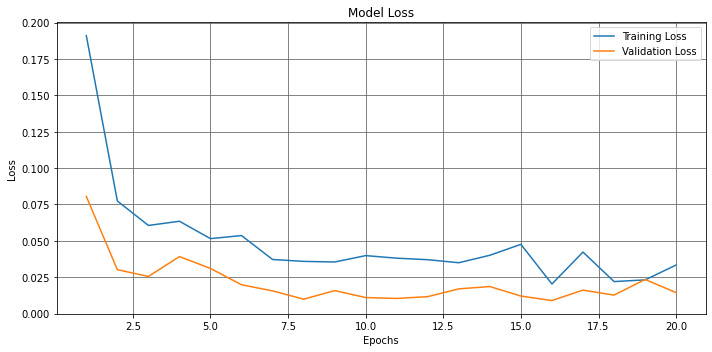

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

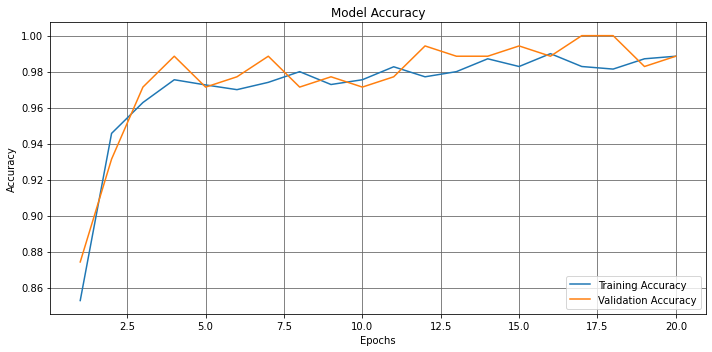

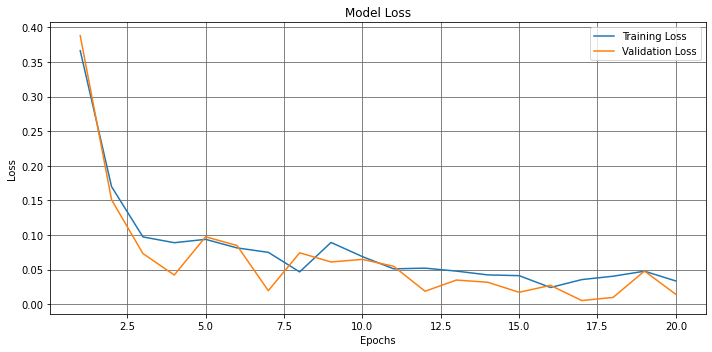

This is the plot of the recorded Accuracy per Activation Type
[0.99, 0.985, 0.9875]


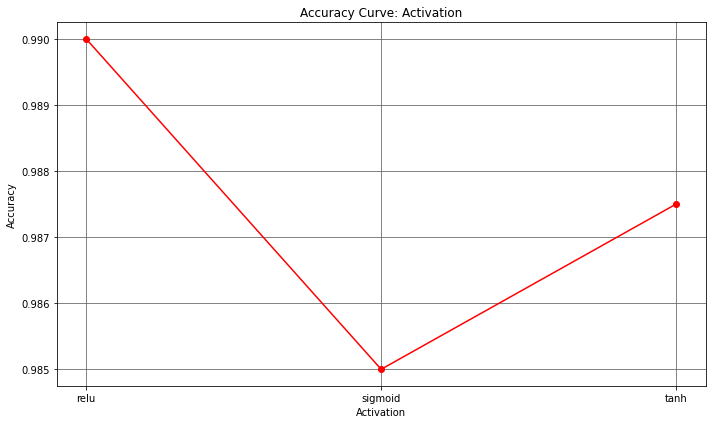

CPU times: user 1min 53s, sys: 10.5 s, total: 2min 3s
Wall time: 2min 38s


In [ ]:
%%time
param_tuning_with_activation( VGG16, activation_types=["relu","sigmoid","tanh"] )

###<h3><strong>Changing the No. of Nodes</strong></h3>

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 15,766,337
Trainable params: 1,050,625
Non-trainable params: 14,715,712
__________________________________

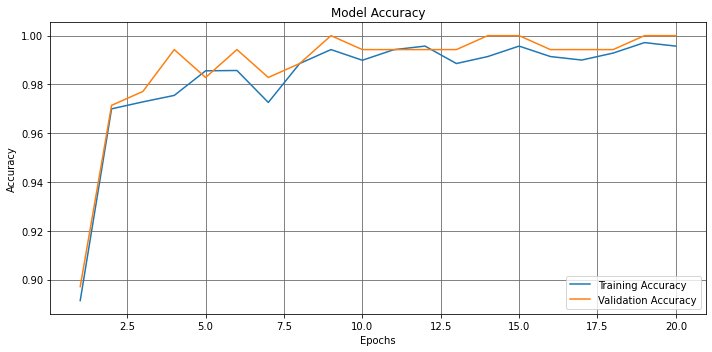

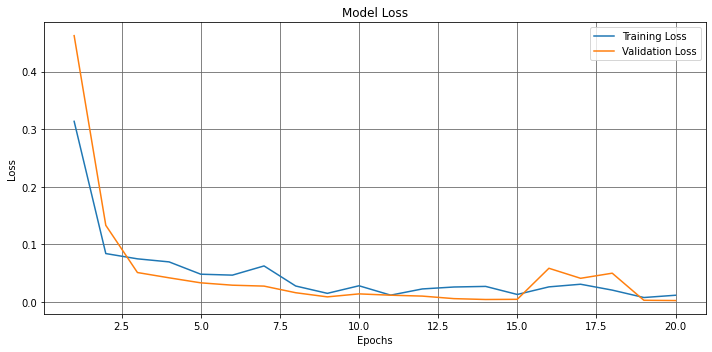

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 1025      
Total params: 16,815,937
Trainable params: 2,100,225
Non-trainable params: 14,715,712
_________________________________

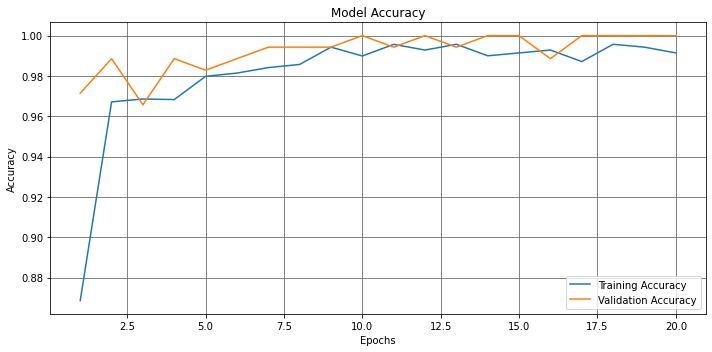

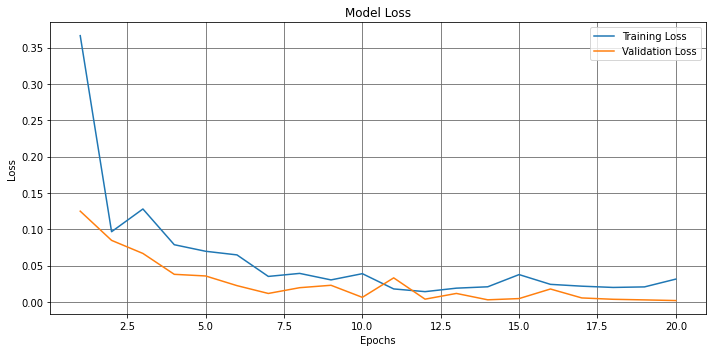

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 2049      
Total params: 18,915,137
Trainable params: 4,199,425
Non-trainable params: 14,715,712
_________________________________

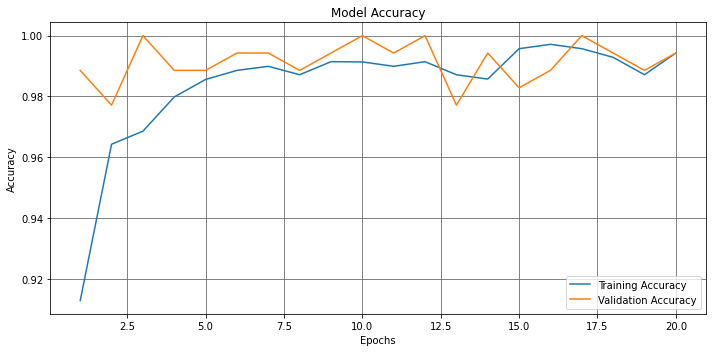

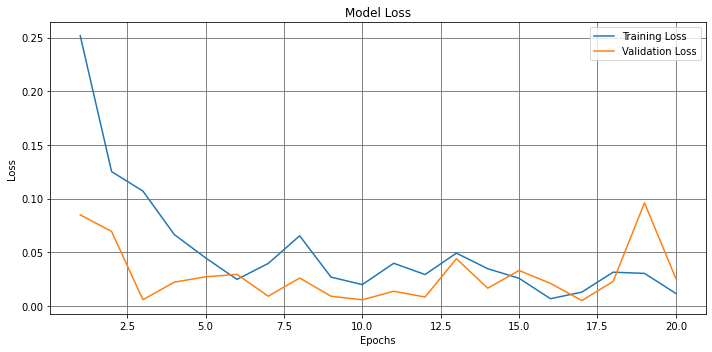

This is the plot of the recorded Accuracy per Number of Nodes in the head of a Transfer Learning model
[0.9875, 0.99, 0.9875]


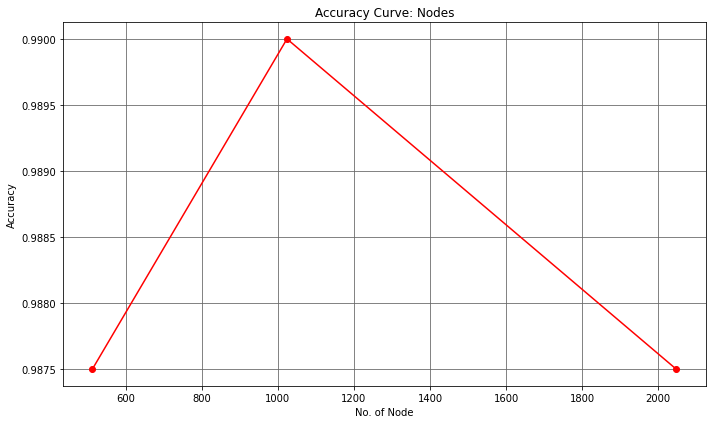

CPU times: user 1min 54s, sys: 10.5 s, total: 2min 4s
Wall time: 2min 43s


In [ ]:
%%time
param_tuning_with_Nodes( VGG16, set_of_nodes = [512,1024,2048] )

###<h3><strong>Building the Best Model with Optimum Values of Hyperparameter</strong></h3><br>

The hyperparameters that have been tested for tuning are as follows: <strong>Dropout Rate</strong>, <strong>Activation</strong> in the hidden layers, and the No. of <strong>Nodes</strong> in the head of the model.

The default values of hyperparameters of the baseline model are as follows:
<ul>
<li>dropout_rate = 0.5</li>
<li>dense_node = 512</li>
<li>activation = "relu"</li>
</ul>

which gives an <strong>accuracy = 0.9925</strong> in the validation set.

On the other hand, during the hyperparameter tuning, it is observed that the optimum values for the said hyperparameters are as follows.

<ul>
<li>dropout_rate = 0.3 and 0.5</li>
<li>dense_node = 1024</li>
<li>activation = "relu"</li>
</ul>

which gives the accuracy of <strong>0.995</strong>, <strong>0.99</strong>, and <strong>0.99</strong> respectively. So these are the values that we will be using to improve the performance of the model. 



In [ ]:
%%time
Tuned_Model_VGG16 = model_builder(VGG16, droupout_rate=0.5, dense_node=1024, activation_type="relu", learning_rate=0.001)
Tuned_Model_VGG16

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_15 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten_15 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 1025      
Total params: 16,815,937
Trainable params: 2,100,225
Non-trainable params: 14,715,712
_________________________________

In [ ]:
%%time
Training_History_TunedVGG16 = model_trainer(Tuned_Model_VGG16, epochs=20)
Training_History_TunedVGG16

Epoch 1/20
50/50 [==============================] - 3s 51ms/step - loss: 0.2101 - accuracy: 0.9086 - val_loss: 0.2161 - val_accuracy: 0.9600
Epoch 2/20
50/50 [==============================] - 2s 46ms/step - loss: 0.1494 - accuracy: 0.9586 - val_loss: 0.0240 - val_accuracy: 0.9829
Epoch 3/20
50/50 [==============================] - 2s 46ms/step - loss: 0.0843 - accuracy: 0.9629 - val_loss: 0.0280 - val_accuracy: 0.9886
Epoch 4/20
50/50 [==============================] - 2s 46ms/step - loss: 0.0795 - accuracy: 0.9769 - val_loss: 0.0142 - val_accuracy: 0.9943
Epoch 5/20
50/50 [==============================] - 2s 46ms/step - loss: 0.0710 - accuracy: 0.9769 - val_loss: 0.0171 - val_accuracy: 0.9886
Epoch 6/20
50/50 [==============================] - 2s 46ms/step - loss: 0.0326 - accuracy: 0.9871 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 7/20
50/50 [==============================] - 2s 46ms/step - loss: 0.0554 - accuracy: 0.9813 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 8/20
50

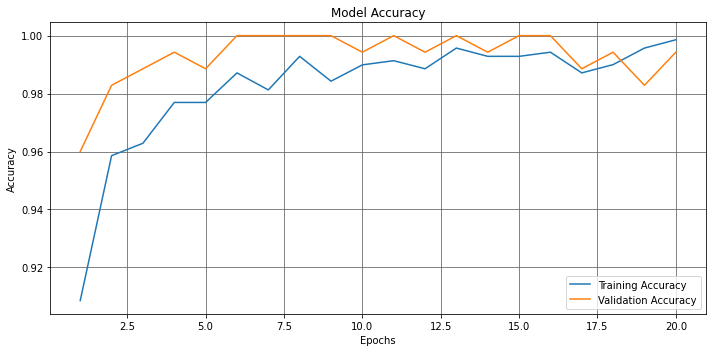

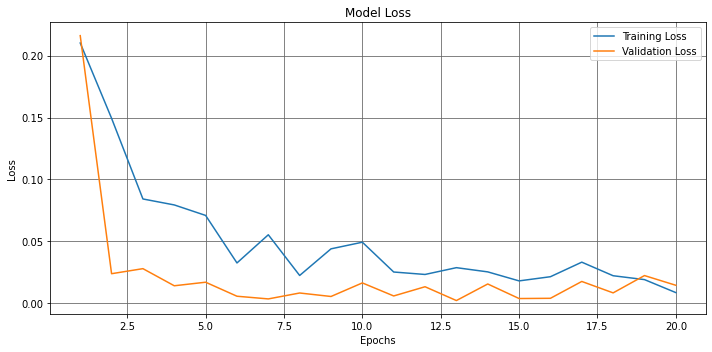

In [ ]:
TunedVGG16_Training_Results = training_result_visualizer(Training_History_TunedVGG16["history"])
TunedVGG16_Training_Results

Accuracy: 0.9975


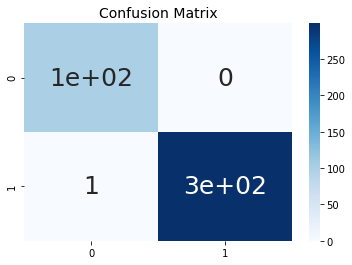

CPU times: user 1.18 s, sys: 166 ms, total: 1.34 s
Wall time: 1.26 s


In [ ]:
%%time
Accuracy_Score(Validation_Path, Training_History_TunedVGG16["model"])

After some trial and error, it turns out that changing the activation from "dense_node" to 1024 will increase the accuracy of the model from 0.9925 to 0.9975 which is only one percent. 

##<h3><strong>Applyin the Tuned Model on Test Set for Final Accuracy</strong></h3>

After choosing the best paramater value in hyperparameter tuning, we are now going to test the accuracy of the tuned model on the test set to report the final accuracy.

Accuracy: 0.995


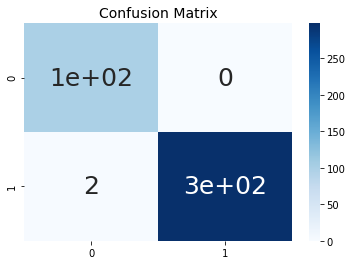

CPU times: user 1.04 s, sys: 144 ms, total: 1.19 s
Wall time: 1.15 s


In [ ]:
%%time
Accuracy_Score(Test_Path, Training_History_TunedVGG16["model"])

##<h3><strong>Summary and Conclusion</strong></h3>

The following practices have been performed in this exercise:
<ul>
<li>Splitting the Dataset</li>
<li>Data Visualization</li>
<li>Creating Helper Functions</li>
<li>Building the Model</li>
<li>Training the Model</li>
<li>Evaluating the Model</li>
<li>Hyperparameter Tuning</li>
<li>Testing the Accuracy of the Model on the Test Set</li>
</ul>

<strong>Before Hyperparameter Tuning</strong><br>
Validation Accuracy: 0.9925

<strong>After Hyperparameter Tuning</strong><br>
Validation Accuracy: 0.9975

<strong>Final Accuracy</strong><br>
Test Accuracy: 0.995

It is observed that the model achieved a fairly high accuracy of 0.9925 on the Validation Set even without highperparameter Tuning. One of the reason for achieving this kind of accuracy is because of the nature of the images. The difference between the images of the two class are very noticeable (see the images below). Even though the model achieved a significanlty high accuracy, it also a good practice to apply hyperparameter tuning to really reach the maximum potential accuracy of the model where it achived 0.9975 accuracy on the Validation Set. Finally, the accuracy of the model on Test Set is 0.995 which indicates that the model really did a good job at classifying ship and no-ship.

<strong>Class: ship</strong>
![](https://i.imgur.com/tLsSoTz.png)
<strong>Class: no-ship</strong>
![](https://i.imgur.com/Q3daQMC.png)